# Import Dependencies

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

In [16]:
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf 
import sys

In [3]:
# importing all scripts that will be needed to export your model and use it for inference
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

# Model Conversion

After Training the model, we invoke export_tflite_graph_tf2.py to generate a TFLite-friendly intermediate SavedModel (which can be found in the saved_model directory)

#### Utility functions

In [6]:
def parse_record(data_record):
    """
    parse the data record from a tfrecord file, typically pulled from an iterator,
    in this case a one_shot_iterator created from the dataset.
    """
    feature = {'image/encoded': tf.io.FixedLenFeature([], tf.string),
               'image/object/class/label': tf.io.VarLenFeature(tf.int64),
               'image/object/bbox/xmin': tf.io.VarLenFeature(tf.float32),
               'image/object/bbox/ymin': tf.io.VarLenFeature(tf.float32),
               'image/object/bbox/xmax': tf.io.VarLenFeature(tf.float32),
               'image/object/bbox/ymax': tf.io.VarLenFeature(tf.float32),
               'image/filename': tf.io.FixedLenFeature([], tf.string),
               'image/object/class/text': tf.io.VarLenFeature(tf.string)
               }
    return tf.io.parse_single_example(data_record, feature)

In [7]:
dataset = tf.data.TFRecordDataset('detrac_MVI_40774.tfrecord', num_parallel_reads=tf.data.experimental.AUTOTUNE) 
record_iterator = iter(dataset)
def representative_dataset_gen():
    for i in range(0,50):
        parsed_example = parse_record(record_iterator.get_next())
        encoded_image = parsed_example['image/encoded']
        image_np = tf.image.decode_image(encoded_image, channels=3)
        image = tf.image.resize(image_np, [300, 300]) 
        image = tf.expand_dims(image, 0)
        yield [image]

In [4]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')

### Non-Quantized TFLite Model

In [8]:
tflite_model = converter.convert()

### Quantized TFLite Model

In [9]:
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce integer only quantization
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8,tf.lite.OpsSet.TFLITE_BUILTINS]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset_gen
converter.allow_custom_ops = True
tflite_quant_model = converter.convert()

# Model Inference

#### Utility functions

In [10]:
path2label_map = 'label_map.pbtxt' # TODO: provide a path to the label map file
category_index = label_map_util.create_category_index_from_labelmap(path2label_map,use_display_name=True)

In [11]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      numpy array with shape (img_height, img_width, 3)
    """
    
    return np.array(Image.open(path))

In [12]:
image_np = load_image_into_numpy_array('sample.jpg')

### Non-Quantized Model Inference

In [13]:
tflite_interpreter = tf.lite.Interpreter(model_content=tflite_model)
tflite_interpreter.allocate_tensors()
tflite_input_details = tflite_interpreter.get_input_details()[0]
tflite_scores = tflite_interpreter.get_output_details()[0]
tflite_classes = tflite_interpreter.get_output_details()[3]
tflite_detections = tflite_interpreter.get_output_details()[2]
tflite_boxes = tflite_interpreter.get_output_details()[1]

Image Preprocessing

In [18]:
image_resize = tf.image.resize(image_np, [300, 300])

normalize_img = (image_resize - 127.5) / 127.5
tflite_input_tensor = np.expand_dims(normalize_img, 0)

In [14]:

tflite_interpreter.set_tensor(tflite_input_details['index'], tflite_input_tensor)
tflite_interpreter.invoke()

tflite_detection_scores = tflite_interpreter.get_tensor(tflite_scores["index"])

output_scale, output_zero_point = tflite_scores["quantization"]
if (output_scale, output_zero_point) != (0.0, 0):
    print("need output quantization",output_scale,output_zero_point)
    tflite_detection_scores = tflite_detection_scores.astype(np.float32)
    tflite_detection_scores = (tflite_detection_scores - output_zero_point) * output_scale

tflite_detection_classes = tflite_interpreter.get_tensor(tflite_classes["index"])
output_scale, output_zero_point = tflite_classes["quantization"]
if (output_scale, output_zero_point) != (0.0, 0):
    print("need output quantization",output_scale,output_zero_point)
    tflite_detection_classes = tflite_detection_classes.astype(np.float32)
    tflite_detection_classes = (tflite_detection_classes - output_zero_point) * output_scale

tflite_num_detections = tflite_interpreter.get_tensor(tflite_detections["index"])
output_scale, output_zero_point = tflite_detections["quantization"]
if (output_scale, output_zero_point) != (0.0, 0):
    print("need output quantization",output_scale,output_zero_point)
    tflite_num_detections = tflite_num_detections.astype(np.float32)
    tflite_num_detections = (tflite_num_detections - output_zero_point) * output_scale

tflite_detection_boxes = tflite_interpreter.get_tensor(tflite_boxes["index"])
output_scale, output_zero_point = tflite_boxes["quantization"]
if (output_scale, output_zero_point) != (0.0, 0):
    print("need output quantization",output_scale,output_zero_point)
    tflite_detection_boxes = tflite_detection_boxes.astype(np.float32)
    tflite_detection_boxes = (tflite_detection_boxes - output_zero_point) * output_scale

tflite_detection_scores = tflite_detection_scores[0]
tflite_detection_classes = tflite_detection_classes[0].astype(np.int64)
tflite_num_detections = tflite_num_detections[0].astype(np.int64)
tflite_detection_boxes = tflite_detection_boxes[0]

tflite_image_detections = image_np.copy()
viz_utils.visualize_boxes_and_labels_on_image_array(
        tflite_image_detections,
        tflite_detection_boxes,
        tflite_detection_classes+1,
        tflite_detection_scores,
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=0.5,
        agnostic_mode=False,
        line_thickness=5)

print('tflite_detection_scores:',tflite_detection_scores)
print('tflite_detection_classes:',tflite_detection_classes)
print('tflite_num_detections:',tflite_num_detections)
print('tflite_detection_boxes:')
for detection in tflite_detection_boxes:
    print(detection)


tflite_detection_scores: [0.88126606 0.8636228  0.8444784  0.83444893 0.82267493 0.7586309
 0.72747076 0.64393556 0.4792308  0.37496698 0.35456866 0.21228562
 0.17112313 0.16550326 0.16282031 0.13535884 0.12606364 0.12315518
 0.09494544 0.08832499]
tflite_detection_classes: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
tflite_num_detections: 20
tflite_detection_boxes:
[0.13898835 0.5581504  0.2226857  0.64273024]
[0.37905622 0.51477677 0.57565093 0.6674817 ]
[0.10336263 0.36700267 0.16064209 0.4233514 ]
[0.17918263 0.47067225 0.25840816 0.5481311 ]
[0.19362032 0.26374823 0.28584093 0.33670342]
[0.19328472 0.03578638 0.2740516  0.08890636]
[0.38459224 0.16602626 0.57033443 0.27695608]
[0.08592343 0.43386286 0.14284348 0.48653913]
[0.0707082  0.43492046 0.12961109 0.48729852]
[0.07322308 0.05297361 0.12850046 0.09446552]
[0.05345578 0.34245595 0.10406741 0.3869144 ]
[0.19365428 0.0161516  0.26964656 0.04439866]
[0.03531459 0.19652161 0.08658443 0.23899463]
[0.05851648 0.00280525 0.116818   0

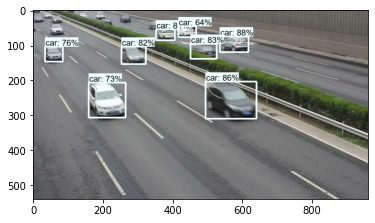

In [17]:
plt.imshow(tflite_image_detections)

### Quantized Model Inference

In [20]:
tflite_interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
tflite_interpreter.allocate_tensors()
tflite_input_details = tflite_interpreter.get_input_details()[0]
tflite_scores = tflite_interpreter.get_output_details()[0]
tflite_classes = tflite_interpreter.get_output_details()[3]
tflite_detections = tflite_interpreter.get_output_details()[2]
tflite_boxes = tflite_interpreter.get_output_details()[1]

Image Preprocessing

In [23]:
image_resize = tf.image.resize(image_np, [300, 300])
# commenting out the normalization part since the input dtype is uint8
# normalize_img = (image_resize - 127.5) / 127.5 
input_img = image_resize.numpy().astype(tflite_input_details["dtype"])
tflite_input_tensor = np.expand_dims(input_img, 0)

In [24]:
tflite_interpreter.set_tensor(tflite_input_details['index'], tflite_input_tensor)
tflite_interpreter.invoke()

tflite_detection_scores = tflite_interpreter.get_tensor(tflite_scores["index"])

output_scale, output_zero_point = tflite_scores["quantization"]
if (output_scale, output_zero_point) != (0.0, 0):
    print("need output quantization",output_scale,output_zero_point)
    tflite_detection_scores = tflite_detection_scores.astype(np.float32)
    tflite_detection_scores = (tflite_detection_scores - output_zero_point) * output_scale

tflite_detection_classes = tflite_interpreter.get_tensor(tflite_classes["index"])
output_scale, output_zero_point = tflite_classes["quantization"]
if (output_scale, output_zero_point) != (0.0, 0):
    print("need output quantization",output_scale,output_zero_point)
    tflite_detection_classes = tflite_detection_classes.astype(np.float32)
    tflite_detection_classes = (tflite_detection_classes - output_zero_point) * output_scale

tflite_num_detections = tflite_interpreter.get_tensor(tflite_detections["index"])
output_scale, output_zero_point = tflite_detections["quantization"]
if (output_scale, output_zero_point) != (0.0, 0):
    print("need output quantization",output_scale,output_zero_point)
    tflite_num_detections = tflite_num_detections.astype(np.float32)
    tflite_num_detections = (tflite_num_detections - output_zero_point) * output_scale

tflite_detection_boxes = tflite_interpreter.get_tensor(tflite_boxes["index"])
output_scale, output_zero_point = tflite_boxes["quantization"]
if (output_scale, output_zero_point) != (0.0, 0):
    print("need output quantization",output_scale,output_zero_point)
    tflite_detection_boxes = tflite_detection_boxes.astype(np.float32)
    tflite_detection_boxes = (tflite_detection_boxes - output_zero_point) * output_scale

tflite_detection_scores = tflite_detection_scores[0]
tflite_detection_classes = tflite_detection_classes[0].astype(np.int64)
tflite_num_detections = tflite_num_detections[0].astype(np.int64)
tflite_detection_boxes = tflite_detection_boxes[0]

tflite_image_detections = image_np.copy()
viz_utils.visualize_boxes_and_labels_on_image_array(
        tflite_image_detections,
        tflite_detection_boxes,
        tflite_detection_classes+1,
        tflite_detection_scores,
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=0.5,
        agnostic_mode=False,
        line_thickness=5)

print('tflite_detection_scores:',tflite_detection_scores)
print('tflite_detection_classes:',tflite_detection_classes)
print('tflite_num_detections:',tflite_num_detections)
print('tflite_detection_boxes:')
for detection in tflite_detection_boxes:
    print(detection)

need output quantization 0.002892732620239258 0
need output quantization 0.0117647061124444 0
need output quantization 0.0784313753247261 0
need output quantization 0.004157773684710264 3
tflite_detection_scores: [0.6016884  0.33555698 0.248775   0.22563314 0.21116948 0.18802762
 0.17645669 0.15331483 0.1417439  0.13017297 0.1243875  0.11860204
 0.11860204 0.11281657 0.11281657 0.11281657 0.10992384 0.10992384
 0.10992384 0.10992384]
tflite_detection_classes: [2 2 2 2 3 3 3 3 3 3 3 3 2 3 3 2 3 3 3 3]
tflite_num_detections: 20
tflite_detection_boxes:
[-0.00831555  0.06652438  1.0061812   1.0061812 ]
[-0.01247332  0.25778198  0.65277046  0.9812346 ]
[0.07068215 0.4615129  1.0477589  0.9978657 ]
[ 0.41993514 -0.00831555  0.9978657   1.0061812 ]
[0.43240845 0.84818584 0.6694016  0.9978657 ]
[0.6361394 0.9271835 1.0477589 0.9895501]
[0.18709981 0.9354991  0.59040385 0.9937079 ]
[0.1579954  0.87313247 0.49893284 1.0020235 ]
[0.661086  0.8689747 0.9853924 1.0020235]
[0.00831555 0.9521302  0.0

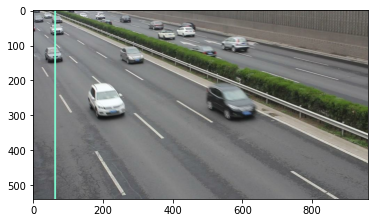

In [25]:
plt.imshow(tflite_image_detections)